In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from prophet.diagnostics import cross_validation, performance_metrics
from suntime import Sun, SunTimeException
from datetime import timedelta
import ephem
import xgboost as xgb
from sklearn.metrics import r2_score
from prophet import Prophet
import joblib
from prophet.serialize import model_to_json, model_from_json
import json

/var/folders/vv/v6qpc6ns2mv0rnx87x54tqhr0000gn/T/ipykernel_21460/214451404.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
latitude = '-2.947600'
longitude = '-60.028500'

# Initialize the observer
observer = ephem.Observer()
observer.lat = latitude
observer.lon = longitude

def is_production_time(time):
    # Set the date for the observer
    observer.date = time.strftime('%Y/%m/%d 00:00:00')

    # Calculate sunrise and sunset times
    sunrise = observer.next_rising(ephem.Sun()).datetime()
    sunset = observer.next_setting(ephem.Sun()).datetime()

    # Adjust times by subtracting 4 hours if needed
    sunrise = sunrise - timedelta(hours=5)
    sunset = sunset - timedelta(hours=3)

    # print('Time: ', time, 'Sunrise: ', sunrise, 'Sunset: ', sunset, 'production_time: ', int(sunrise <= time <= sunset))

    # Check if the time is between the adjusted sunrise and sunset times
    return int(sunrise <= time <= sunset)

In [3]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

def cap_outliers(data):
    capped_data = data.copy()
    lower_bound = data['System Production (W)'].quantile(0.05)
    upper_bound = data['System Production (W)'].quantile(0.95)

    capped_data['System Production (W)'] = np.where(capped_data['System Production (W)'] < lower_bound, lower_bound,
                                                    np.where(capped_data['System Production (W)'] > upper_bound, upper_bound,
                                                            capped_data['System Production (W)']))
    return capped_data

def create_lagged_features(df, column, lags):
    for lag in range(1, lags + 1):
        df[f'{column}_lag{lag}'] = df[column].shift(lag)
    return df

In [4]:
def get_data():
    file_path = '/Users/mubashirahmad/BDTI_Lab/Projects/ProjPowerbox/Data/processed_datasets/Solar_Iradiance_Plus_Solar_Power_Data.csv'
    data = pd.read_csv(file_path, usecols=['Time', 'System Production (W)','ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UV_INDEX', 'T2MWET', 'ALLSKY_SFC_PAR_TOT', 'ALLSKY_SRF_ALB', 'CLRSKY_SFC_SW_DWN', 'T2M', 'ALLSKY_KT', 'CLRSKY_SFC_PAR_TOT', 'ALLSKY_SFC_SW_DIFF', 'ALLSKY_SFC_SW_DNI', 'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UVA'])
    data['System Production (W)'] = data['System Production (W)'] / 1000
    data['System Production (W)'] = data['System Production (W)'].replace(0, 0.001)
    data['System Production (W)'] = np.log(data['System Production (W)'])
    # outliers = detect_outliers_iqr(data['System Production (W)'])
    # if len(outliers) > 0:
    #     data = cap_outliers(data)
     
    n = len(data)
    train_size = int(n * 0.80)
    valid_size = int(n * 0.15)

    train_data = data.iloc[:train_size]
    valid_data = data.iloc[train_size:train_size + valid_size]
    test_data = data.iloc[train_size + valid_size:]
    
    
    # print("Training set mean:", train_data['System Production (W)'].mean())
    # print("Validation set mean:", valid_data['System Production (W)'].mean())

    # print("Training set std dev:", train_data['System Production (W)'].std())
    # print("Validation set std dev:", valid_data['System Production (W)'].std())
    
    
    
    return train_data, valid_data, test_data, data

In [5]:
variables = ['ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UV_INDEX', 'T2MWET', 'ALLSKY_SFC_PAR_TOT', 
                 'ALLSKY_SRF_ALB', 'CLRSKY_SFC_SW_DWN', 'T2M', 'ALLSKY_KT', 'CLRSKY_SFC_PAR_TOT', 
                 'ALLSKY_SFC_SW_DIFF', 'ALLSKY_SFC_SW_DNI', 'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UVA',
                 'System Production (W)_lag1','System Production (W)_lag2','System Production (W)_lag3']
def data_init():
    train, valid, test, data = get_data()
    
    # Ensure we are working with copies to avoid SettingWithCopyWarning
    train = train.copy()
    valid = valid.copy()
    test = test.copy()

    train['Time'] = pd.to_datetime(train['Time'])
    train['production_time'] = train['Time'].apply(is_production_time)
    #train['System Production (W)'] = train['System Production (W)'].replace(0, 0.001)
   
    
    valid['Time'] = pd.to_datetime(valid['Time'])
    valid['production_time'] = valid['Time'].apply(is_production_time)
    # old_valid = valid.copy()
    
    test['Time'] = pd.to_datetime(test['Time'])
    test['production_time'] = test['Time'].apply(is_production_time)
    # old_test = test.copy()
    # train = train[train.production_time == 1]
    # valid = valid[valid.production_time == 1]
    # test = test[test.production_time == 1]
    print(len(train), len(valid), len(test))
    
    
    
    # Create lagged features for 'System Production (W)' (using 3 lags as an example)
    train = create_lagged_features(train, 'System Production (W)', 3)
    valid = create_lagged_features(valid, 'System Production (W)', 3)
    test = create_lagged_features(test, 'System Production (W)', 3)
    

    # Drop rows with NaN values created by lagging
    train = train.dropna().reset_index(drop=True)
    valid = valid.dropna().reset_index(drop=True)
    test = test.dropna().reset_index(drop=True)
    

    # Robust Scaler for System Production
    # scaler = RobustScaler()
    # train['System Production (W)'] = scaler.fit_transform(train[['System Production (W)']])
    # valid['System Production (W)'] = scaler.transform(valid[['System Production (W)']])

    # Robust Scaler for all other variables
    

    for i,var in enumerate(variables):
        add_scaler = RobustScaler()
        train[var] = add_scaler.fit_transform(train[[var]])
        joblib.dump(add_scaler, f'/Users/mubashirahmad/Library/CloudStorage/OneDrive-UniversityofHertfordshire/BDTI-Shared-Resources/Projects/On-Going/PowerBox/powerbox/powerbox/Model_Development/prophet/add_scaler_{i}.pkl')
    
    return train, valid, test

In [6]:
train, valid,test= data_init()

# Load the scaler

for i, var in enumerate(variables):
    loaded_add_scaler = joblib.load(f'/Model_Development/prophet/add_scaler_{i}.pkl')

    valid[var] = loaded_add_scaler.transform(valid[[var]])
    test[var] = loaded_add_scaler.transform(test[[var]])

# keys = ['Time', 'System Production (W)','production_time', 'System Production (W)_lag1', 'System Production (W)_lag2',
#         'System Production (W)_lag3', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UV_INDEX', 'T2MWET',
#         'ALLSKY_SFC_PAR_TOT', 'ALLSKY_SRF_ALB', 'CLRSKY_SFC_SW_DWN', 'T2M', 'ALLSKY_KT',
#         'CLRSKY_SFC_PAR_TOT', 'ALLSKY_SFC_SW_DIFF', 'ALLSKY_SFC_SW_DNI', 'ALLSKY_SFC_UVB',
#         'ALLSKY_SFC_UVA']

# # Corresponding values
# values = ['ds', 'y'] + [f'add{i}' for i in range(1, len(keys) - 1)]


# columns = {keys[i]: values[i] for i in range(len(keys))}

# # Prepare data for Prophet
# train_prophet = train.reset_index().rename(columns= {keys[i]: values[i] for i in range(len(keys))})

# valid_prophet = valid.reset_index().rename(columns= {keys[i]: values[i] for i in range(len(keys))})

# test_prophet = test.reset_index().rename(columns= {keys[i]: values[i] for i in range(len(keys))})

# train_prophet = train_prophet[['ds', 'y', 'add1', 'add2', 'add3', 'add4', 'add5', 'add6', 'add7', 'add8', 'add9', 'add10', 'add11', 'add12', 'add13', 'add14', 'add15', 'add16']]
# valid_prophet = valid_prophet[['ds', 'add1', 'add2', 'add3', 'add4', 'add5', 'add6', 'add7', 'add8', 'add9', 'add10', 'add11', 'add12', 'add13', 'add14', 'add15', 'add16']]
# test_prophet = test_prophet[['ds', 'add1', 'add2', 'add3', 'add4', 'add5', 'add6', 'add7', 'add8', 'add9', 'add10', 'add11', 'add12', 'add13', 'add14', 'add15', 'add16']]


keys = [
    'Time', 'System Production (W)','production_time',  'System Production (W)_lag1', 'System Production (W)_lag2',
    'System Production (W)_lag3', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UV_INDEX', 'T2MWET',
    'ALLSKY_SFC_PAR_TOT', 'ALLSKY_SRF_ALB', 'CLRSKY_SFC_SW_DWN', 'T2M', 'ALLSKY_KT',
    'CLRSKY_SFC_PAR_TOT', 'ALLSKY_SFC_SW_DIFF', 'ALLSKY_SFC_SW_DNI', 'ALLSKY_SFC_UVB',
    'ALLSKY_SFC_UVA'
]

# Generate the corresponding column mapping
values = ['ds', 'y'] + [f'add{i}' for i in range(1, len(keys) - 2)]
column_mapping = dict(zip(keys, values))

# Function to rename and filter data for Prophet
def prepare_prophet_data(df, column_mapping, is_train=True):
    # Rename columns
    df_renamed = df.reset_index().rename(columns=column_mapping)
    
    # Select relevant columns for Prophet
    selected_columns = ['ds', 'y'] + [f'add{i}' for i in range(1, len(keys)-2)] if is_train else ['ds'] + [f'add{i}' for i in range(1, len(keys)-2)]
    
    # Return the filtered dataframe
    return df_renamed[selected_columns]

# Prepare data for Prophet
train_prophet = prepare_prophet_data(train, column_mapping, is_train=True)
valid_prophet = prepare_prophet_data(valid, column_mapping, is_train=False)
test_prophet = prepare_prophet_data(test, column_mapping, is_train=False)



# Initialize Prophet model
model = Prophet(yearly_seasonality=True, 
                weekly_seasonality=False, 
                daily_seasonality=False, 
                
                )

# Add custom daily seasonality
model.add_seasonality(name='daily', period=24, fourier_order=200)

# Add all regressors
for i in range(1, len(keys)-16):
    model.add_regressor(f'add{i}')

# Fit model
model.fit(train_prophet)
with open('Model_Development/prophet/prophet_model.json', 'w') as f:
    json.dump(model_to_json(model), f)  # Save the model as a JSON file




15184 2847 949


16:01:11 - cmdstanpy - INFO - Chain [1] start processing
16:01:24 - cmdstanpy - INFO - Chain [1] done processing


## Validation

In [9]:
# Validation
future = valid_prophet.copy()

with open('/Model_Development/prophet/prophet_model.json', 'r') as f:
    loaded_model = model_from_json(json.load(f))


forecast = loaded_model.predict(future)

# Inverse transform predictions
final_forecast = forecast.copy()
# final_forecast['yhat'] = scaler.inverse_transform(final_forecast[['yhat']])

# Inverse transform validation data
# t = old_valid[old_valid.production_time == 0]
# t['yhat'] = 0
# t = t[['Time','System Production (W)', 'yhat']]

final_valid = valid.copy()
# final_valid['System Production (W)'] = scaler.inverse_transform(final_valid[['System Production (W)']])

# Merge forecast with validation set
final_valid = pd.merge(final_valid, final_forecast[['ds', 'yhat']], left_on='Time', right_on='ds', how='inner')
# final_valid['yhat'] = final_valid['yhat'].apply(lambda x: 0 if x < 0 else x)
# final_valid['production_time'] = final_valid['Time'].apply(is_production_time)
# final_valid.loc[final_valid['production_time'] == 0, 'yhat'] = 0
# final_valid = final_valid[['Time', 'System Production (W)','yhat']]
# final_valid = pd.concat([t[['Time','System Production (W)', 'yhat']], final_valid[['Time','System Production (W)', 'yhat']]])
# final_valid = final_valid.sort_values(by='Time').reset_index(drop=True)


# final_valid['System Production (W)'] = np.exp(final_valid['System Production (W)'])
# final_valid['yhat'] = np.exp(final_valid['yhat'])
# Calculate errors
mae = mean_absolute_error(final_valid['System Production (W)'], final_valid['yhat'])
rmse = np.sqrt(mean_squared_error(final_valid['System Production (W)'], final_valid['yhat']))

r2 = r2_score(final_valid['System Production (W)'], final_valid['yhat'])
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')
# print(train_prophet['ds'].min(), train_prophet['ds'].max())
# df_cv = cross_validation(model, initial='300 days', period='60 days', horizon='90 days')
# df_p = performance_metrics(df_cv)
# print(df_p[['mae', 'mse', 'rmse']])

Mean Absolute Error: 0.7890953351411998
Root Mean Squared Error: 1.2555903617229467
R² Score: 0.9546037014928104


In [15]:
start_index = np.random.randint(0, len(final_valid) - 10)
temp_2 = final_valid.iloc[start_index:start_index + 10]
print(temp_2[['Time', 'System Production (W)', 'yhat']])

                    Time  System Production (W)      yhat
2138 2023-12-23 21:00:00              -6.907755 -6.677985
2139 2023-12-23 22:00:00              -6.907755 -7.478025
2140 2023-12-23 23:00:00              -6.907755 -6.709182
2141 2023-12-24 00:00:00              -6.907755 -6.823686
2142 2023-12-24 01:00:00              -6.907755 -7.455375
2143 2023-12-24 02:00:00              -6.907755 -6.598917
2144 2023-12-24 03:00:00              -6.907755 -6.841519
2145 2023-12-24 04:00:00              -6.907755 -7.868069
2146 2023-12-24 05:00:00              -4.055124 -4.106283
2147 2023-12-24 06:00:00               2.355918  2.040835


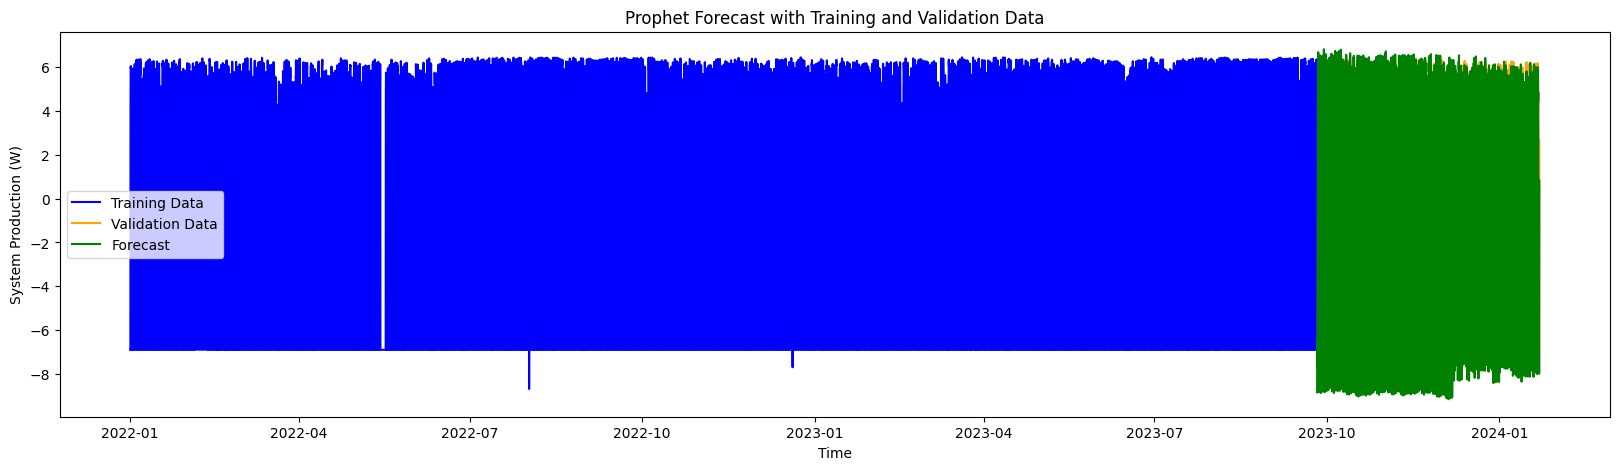

In [16]:
fig, ax = plt.subplots(figsize=(20, 5))

plt.plot(train['Time'], train[['System Production (W)']], label='Training Data', color='blue')

# # Plot the validation data
plt.plot(final_valid['Time'], final_valid['System Production (W)'], label='Validation Data', color='orange')

# # # Plot the forecast data
plt.plot(final_valid['Time'], final_valid['yhat'], label='Forecast', color='green')


# fig = model.plot(forecast, ax=ax)



# Add labels, title, and legend
plt.xlabel('Time')
plt.ylabel('System Production (W)')
plt.title('Prophet Forecast with Training and Validation Data')
plt.legend()

plt.show()

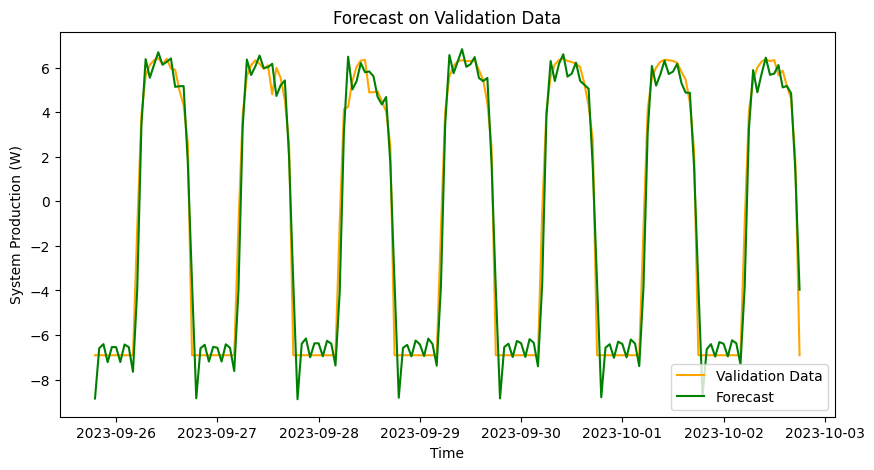

In [17]:
# forecast['ds'] = pd.to_datetime(forecast['ds'])
# valid['Time'] = pd.to_datetime(valid['Time'])

# Filter for the first week in the forecast
first_week_forecast = final_forecast[(final_forecast['ds'] >= final_valid['Time'].min()) & (final_forecast['ds'] < final_valid['Time'].min() + pd.Timedelta(days=7))]

# Filter the validation data for the first week
first_week_valid = final_valid[(final_valid['Time'] >= final_valid['Time'].min()) & (final_valid['Time'] < final_valid['Time'].min() + pd.Timedelta(days=7))]

# Plotting the first week of forecast vs validation
plt.figure(figsize=(10, 5))

# Plot the validation data
plt.plot(first_week_valid['Time'], first_week_valid['System Production (W)'], label='Validation Data', color='orange')

# Plot the forecasted data
plt.plot(first_week_forecast['ds'], first_week_valid['yhat'], label='Forecast', color='green')

# Customize the plot
plt.title('Forecast on Validation Data')
plt.xlabel('Time')
plt.ylabel('System Production (W)')
plt.legend()

# Display the plot
plt.show()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python date

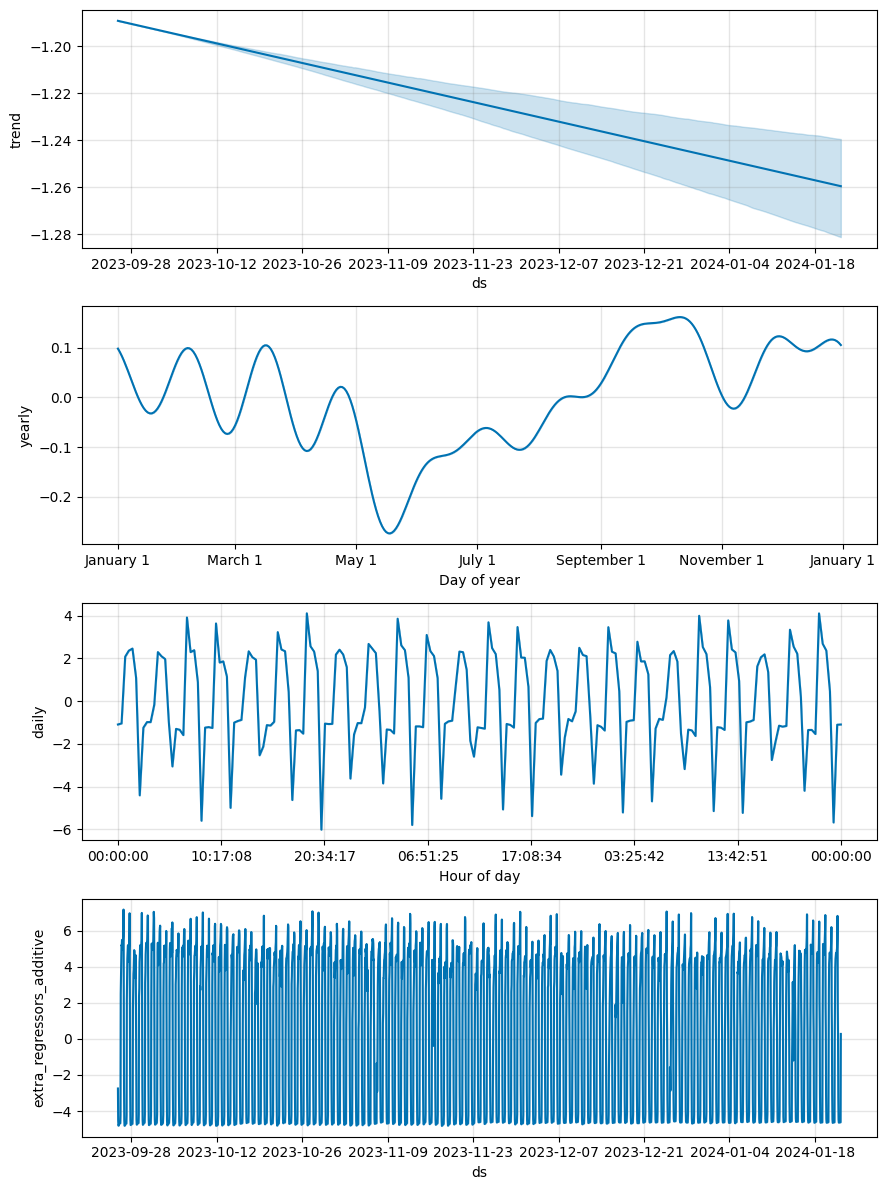

In [66]:
fig = loaded_model.plot_components(forecast)
plt.show()

## Testing

In [67]:
with open('/Model_Development/prophet/prophet_model.json', 'r') as f:
    loaded_model = model_from_json(json.load(f))

future = test_prophet.copy()
forecast = loaded_model.predict(future)
final_forecast = forecast.copy()

# final_forecast['yhat'] = scaler.inverse_transform(final_forecast[['yhat']])

# Inverse transform validation data
# t = old_valid[old_valid.production_time == 0]
# t['yhat'] = 0
# t = t[['Time','System Production (W)', 'yhat']]

final_test = test.copy()
# final_valid['System Production (W)'] = scaler.inverse_transform(final_valid[['System Production (W)']])

# Merge forecast with validation set
final_test = pd.merge(final_test, final_forecast[['ds', 'yhat']], left_on='Time', right_on='ds', how='inner')
final_test['yhat'] = final_test['yhat'].apply(lambda x: 0 if x < 0 else x)
final_test['production_time'] = final_test['Time'].apply(is_production_time)
final_test.loc[final_test['production_time'] == 0, 'yhat'] = 0
# final_valid = final_valid[['Time', 'System Production (W)','yhat']]
# final_valid = pd.concat([t[['Time','System Production (W)', 'yhat']], final_valid[['Time','System Production (W)', 'yhat']]])
# final_valid = final_valid.sort_values(by='Time').reset_index(drop=True)

# Calculate errors
mae = mean_absolute_error(final_test['System Production (W)'], final_test['yhat'])
rmse = np.sqrt(mean_squared_error(final_test['System Production (W)'], final_test['yhat']))

r2 = r2_score(final_test['System Production (W)'], final_test['yhat'])
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')

Mean Absolute Error: 3.532077677799347
Root Mean Squared Error: 4.7489264873204595
R² Score: 0.34487973065554356


In [68]:
start_index = np.random.randint(0, len(final_test) - 10)
temp_2 = final_test.iloc[start_index:start_index + 10]
print(temp_2[['Time', 'System Production (W)', 'yhat']])

                   Time  System Production (W)  yhat
753 2024-02-22 19:00:00              -6.907755   0.0
754 2024-02-22 20:00:00              -6.907755   0.0
755 2024-02-22 21:00:00              -6.907755   0.0
756 2024-02-22 22:00:00              -6.907755   0.0
757 2024-02-22 23:00:00              -6.907755   0.0
758 2024-02-23 00:00:00              -6.907755   0.0
759 2024-02-23 01:00:00              -6.907755   0.0
760 2024-02-23 02:00:00              -6.907755   0.0
761 2024-02-23 03:00:00              -6.907755   0.0
762 2024-02-23 04:00:00              -6.907755   0.0


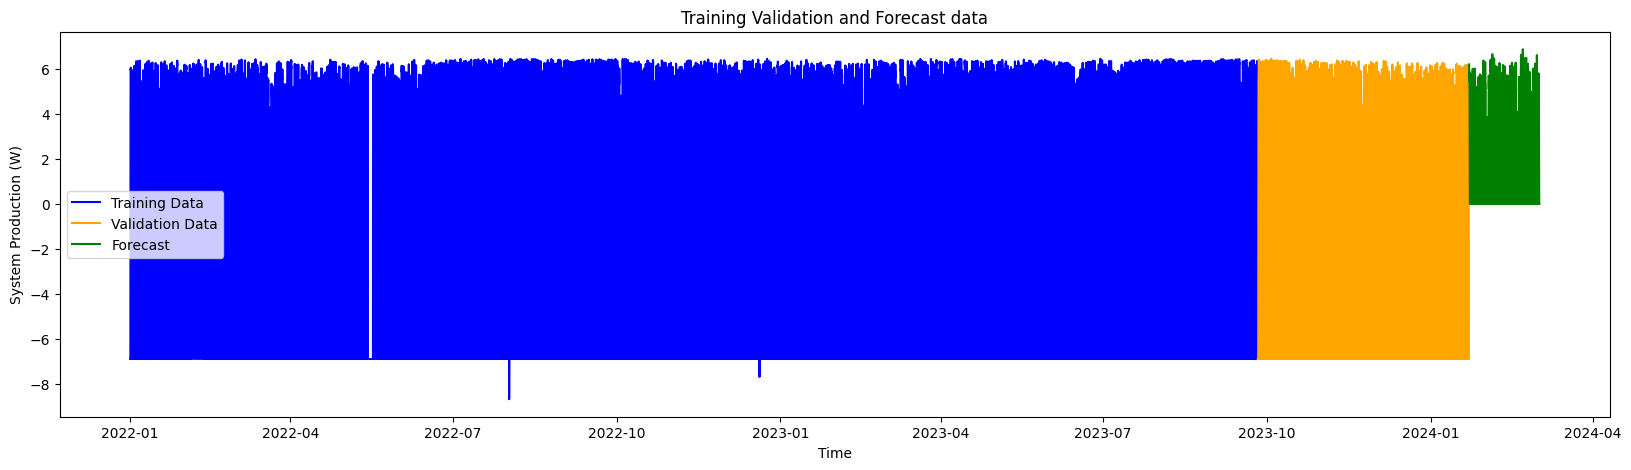

In [69]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(train['Time'], train[['System Production (W)']], label='Training Data', color='blue')
plt.plot(final_valid['Time'], final_valid['System Production (W)'], label='Validation Data', color='orange')

plt.plot(final_test['Time'], final_test['yhat'], label='Forecast', color='green')
# fig = model.plot(forecast, ax=ax)
plt.xlabel('Time')
plt.ylabel('System Production (W)')
plt.title('Training Validation and Forecast data')
plt.legend()

plt.show()

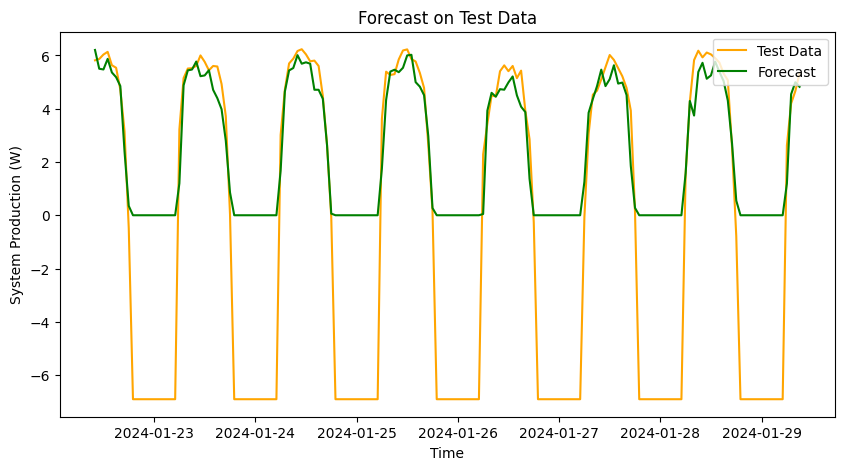

In [70]:
# forecast['ds'] = pd.to_datetime(forecast['ds'])
# valid['Time'] = pd.to_datetime(valid['Time'])

# Filter for the first week in the forecast
first_week_forecast = final_forecast[(final_forecast['ds'] >= final_test['Time'].min()) & (final_forecast['ds'] < final_test['Time'].min() + pd.Timedelta(days=7))]

# Filter the validation data for the first week
first_week_test = final_test[(final_test['Time'] >= final_test['Time'].min()) & (final_test['Time'] < final_test['Time'].min() + pd.Timedelta(days=7))]

# Plotting the first week of forecast vs validation
plt.figure(figsize=(10, 5))

# Plot the validation data
plt.plot(first_week_test['Time'], first_week_test['System Production (W)'], label='Test Data', color='orange')

# Plot the forecasted data
plt.plot(first_week_forecast['ds'], first_week_test['yhat'], label='Forecast', color='green')

# Customize the plot
plt.title('Forecast on Test Data')
plt.xlabel('Time')
plt.ylabel('System Production (W)')
plt.legend()

# Display the plot
plt.show()

In [97]:
class Solution(object):
    def removeElement(self, nums, val):
        k=0
        t = []
        
        for j in nums:
            if j != val:
                t.insert(0,j)
                k+=1

        return k, t
        




solution = Solution()
# nums = [3,2,2,3] 
# val = 3

nums = [0,1,2,2,3,0,4,2]
val = 2
k,  nums = solution.removeElement(nums, val)

print(k, t)

5 [4, 0, 3, 1, 0]


In [79]:
late_fee.append(1)

In [80]:
late_fee

[1]